In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [2]:
#load mnist dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, drop_last=True)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, drop_last=True)

In [3]:
def get_one_hot_labels(labels, n_classes):
    return F.one_hot(labels, n_classes).float()

In [4]:
labels = torch.tensor([1, 2, 3, 4, 5, 6, 7, 8, 9, 0])
one_hot_labels = get_one_hot_labels(labels, 10)
print(one_hot_labels)

tensor([[0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])


In [5]:
labels = torch.randint(0, 10, (10,))
print(labels)
get_one_hot_labels(labels, 10)

tensor([6, 0, 0, 8, 7, 5, 8, 8, 3, 6])


tensor([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]])

In [6]:
def combine_vectors(x, y):
    return torch.cat((x.float(), y.float()), 1)

In [7]:
X = torch.randn(10, 100)
Y = get_one_hot_labels(labels, 10)
combined = combine_vectors(X, Y)

In [8]:
combined.shape

torch.Size([10, 110])

In [9]:
combined.shape

torch.Size([10, 110])

In [10]:
# Generator
class cGAN_Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_classes):
        super(cGAN_Generator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_classes = n_classes
        self.seq = nn.Sequential(
            nn.Linear(self.input_size + self.n_classes, self.hidden_size),
            nn.ReLU(),
            nn.Linear(self.hidden_size, self.hidden_size * 2),
            nn.ReLU(),
            nn.Linear(self.hidden_size * 2, self.hidden_size * 4),
            nn.ReLU(),
            nn.Linear(self.hidden_size * 4, self.output_size),
            nn.Tanh()
        )
    def forward(self, x, y):
        combined = combine_vectors(x, y)
        return self.seq(combined)

In [11]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [12]:
input_size = 100
hidden_size = 128
output_size = 784
n_classes = 10
generator = cGAN_Generator(input_size, hidden_size, output_size, n_classes).to(device)

In [13]:
batch_size = 64
noise = torch.randn(batch_size, input_size).to(device)
labels = torch.randint(0, n_classes, (batch_size,)).to(device)
one_hot_labels = get_one_hot_labels(labels, n_classes).to(device)
gen_out = generator(noise, one_hot_labels)
print(gen_out.shape)

torch.Size([64, 784])


In [14]:
# Discriminator
class cGAN_Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_classes):
        super(cGAN_Discriminator, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_classes = n_classes
        self.seq = nn.Sequential(
            nn.Linear(self.input_size + self.n_classes, self.hidden_size * 4),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(self.hidden_size * 4, self.hidden_size * 2),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(self.hidden_size * 2, self.hidden_size),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.Linear(self.hidden_size, self.output_size),
            nn.Sigmoid()
        )
    def forward(self, x, y):
        combined = combine_vectors(x, y)
        return self.seq(combined)

In [15]:
input_size = 784
hidden_size = 128
output_size = 1
n_classes = 10
discriminator = cGAN_Discriminator(input_size, hidden_size, output_size, n_classes).to(device)

In [16]:
#feed the generator output to the discriminator
disc_out = discriminator(gen_out, one_hot_labels)
print(disc_out.shape)

torch.Size([64, 1])


In [17]:
#loss function and optimizers
criterion = nn.BCELoss()
lr = 0.0002
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr)
g_optimizer = optim.Adam(generator.parameters(), lr=lr)

In [18]:
#training
num_epochs = 500
total_step = len(trainloader)
d_losses = []
g_losses = []
for epoch in range(num_epochs):
    for i, (images, real_labels) in enumerate(trainloader):
        #train the discriminator on real images
        images = images.reshape(batch_size, -1).to(device)
        real_labels = real_labels.to(device)
        real_labels_one_hot = get_one_hot_labels(real_labels, n_classes).to(device)
        real_outputs = discriminator(images, real_labels_one_hot).view(-1)
        d_loss_real = criterion(real_outputs, torch.ones_like(real_outputs))
        real_score = real_outputs
        #train the discriminator on fake images
        z = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
        fake_labels_one_hot = get_one_hot_labels(fake_labels, n_classes).to(device)
        fake_images = generator(z, fake_labels_one_hot)
        fake_outputs = discriminator(fake_images, fake_labels_one_hot).view(-1)
        d_loss_fake = criterion(fake_outputs, torch.zeros_like(fake_outputs))
        fake_score = fake_outputs
        #backprop and optimize
        d_loss = d_loss_real + d_loss_fake
        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        #train the generator
        z = torch.randn(batch_size, 100).to(device)
        fake_labels = torch.randint(0, n_classes, (batch_size,)).to(device)
        fake_labels_one_hot = get_one_hot_labels(fake_labels, n_classes).to(device)
        fake_images = generator(z, fake_labels_one_hot)
        outputs = discriminator(fake_images, fake_labels_one_hot).view(-1)
        g_loss = criterion(outputs, torch.ones_like(outputs))
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()
        if (i+1) % 200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}'
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(),
                          real_score.mean().item(), fake_score.mean().item()))
    d_losses.append(d_loss.item())
    g_losses.append(g_loss.item())

Epoch [0/500], Step [200/937], d_loss: 0.1007, g_loss: 3.0640, D(x): 1.00, D(G(z)): 0.09
Epoch [0/500], Step [400/937], d_loss: 0.0524, g_loss: 11.2967, D(x): 0.98, D(G(z)): 0.02
Epoch [0/500], Step [600/937], d_loss: 0.5747, g_loss: 3.0142, D(x): 0.88, D(G(z)): 0.26
Epoch [0/500], Step [800/937], d_loss: 0.2702, g_loss: 4.9272, D(x): 0.89, D(G(z)): 0.09
Epoch [1/500], Step [200/937], d_loss: 1.0524, g_loss: 1.7431, D(x): 0.71, D(G(z)): 0.31
Epoch [1/500], Step [400/937], d_loss: 0.2926, g_loss: 3.1496, D(x): 0.92, D(G(z)): 0.13
Epoch [1/500], Step [600/937], d_loss: 0.3140, g_loss: 3.8073, D(x): 0.90, D(G(z)): 0.05
Epoch [1/500], Step [800/937], d_loss: 0.4881, g_loss: 2.1398, D(x): 0.89, D(G(z)): 0.17
Epoch [2/500], Step [200/937], d_loss: 0.1859, g_loss: 4.4401, D(x): 0.92, D(G(z)): 0.05
Epoch [2/500], Step [400/937], d_loss: 0.3911, g_loss: 2.5322, D(x): 0.91, D(G(z)): 0.16
Epoch [2/500], Step [600/937], d_loss: 0.3809, g_loss: 3.9346, D(x): 0.92, D(G(z)): 0.14
Epoch [2/500], Step 

In [25]:
#generate images
z = torch.randn(batch_size, 100).to(device)
fake_labels = torch.randint(0,5, (batch_size,)).to(device)
fake_labels_one_hot = get_one_hot_labels(fake_labels, n_classes).to(device)
fake_images = generator(z, fake_labels_one_hot)
fake_images = fake_images.reshape(batch_size, 1, 28, 28)
fake_images = fake_images.detach().cpu()

In [26]:
fake_images.shape

torch.Size([64, 1, 28, 28])

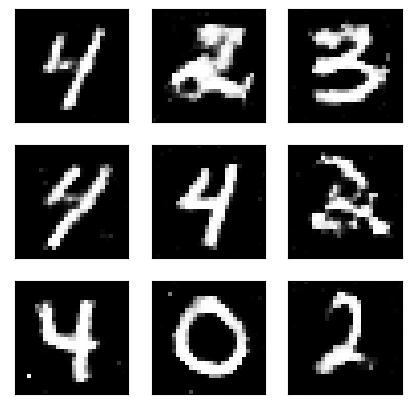

In [27]:
#3x3 grid of images
fig, axes = plt.subplots(nrows=3, ncols=3, sharex=True, sharey=True, figsize=(5,5))
for ax, img in zip(axes.flatten(), fake_images):
    img = img.numpy()
    img = np.transpose(img, (1, 2, 0))
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

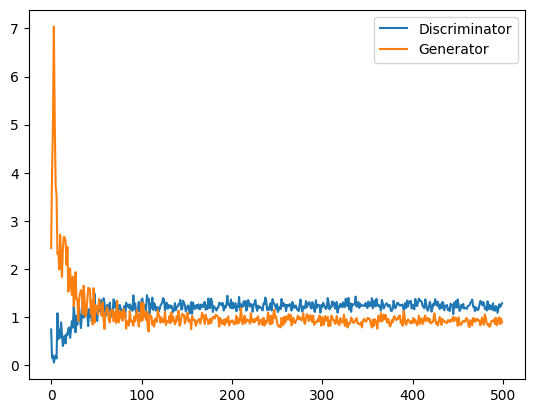

In [28]:
#plot losses
plt.plot(d_losses, label='Discriminator')
plt.plot(g_losses, label='Generator')
plt.legend()
plt.show()